In [ ]:
%load_ext autoreload
%autoreload 2

import os, sys, glob
import torch
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchmetrics

import jiwer
from unidecode import unidecode
import re
import string

In [ ]:
1 + 1

In [2]:
from functools import lru_cache

class SpeechDataset(torch.utils.data.Dataset):   
    def __init__(self, X, y, z=None, toggle_phones = False):
        '''Inputs are:
            X (list of 2D arrays) - entries are time x channels of neural activity
            y (list of 1D arrays) - entries are integer-encoded target strings (character or phoneme)
            z (list of ints)      - entries are session IDs'''
        
        assert len(X) == len(y), 'Target and predictor lists must be same length'
        if z is not None:
            assert len(X) == len(z), 'Target and session ID lists must be same length'
            
        self.X = X
        self.y = y
        self.z = z
        self.num_features   = self.X[0].shape[1]
        self.toggle_phones  = toggle_phones
        self.text_transform = TextTransform(toggle_phones = self.toggle_phones)
        self.smoothed       = False
        
    def __len__(self):
        return len(self.X)

    #@lru_cache
    def __getitem__(self, index):        
        if self.z is not None:
            return (self.X[index], self.y[index], self.z[index])
        else:
            return (self.X[index], self.y[index])
        
    def smooth_data(self, sigma):
        if not self.smoothed and sigma > 0:
            for idx in range(len(self.X)):
                self.X[idx] = gaussian_filter1d(self.X[idx], sigma = sigma, causal=True, axis = 0)
            self.smoothed = True
        else:
            print('Warning: data already smoothed. Skipping...')
    
    
    def collate_fn(self, batch):
        '''
        Padds batch of variable length
        '''
        # get sequence lengths
        lengths = torch.tensor([t[0].shape[0] for t in batch])
        # pad
        batch_x = [torch.tensor(t[0]) for t in batch]
        batch_x = torch.nn.utils.rnn.pad_sequence(batch_x, batch_first=True)
        
        datas = dict()
        datas['neural']           = batch_x
        datas['text_int']         = [torch.tensor(t[1]) for t in batch]
        datas['text_int_lengths'] = torch.tensor([ex[ex != 0].shape[0] for ex in datas['text_int']])
        datas['lengths']          = lengths
        if self.z is not None:
            datas['session_ids'] = torch.tensor([t[2] for t in batch])
        else:
            datas['session_ids'] = None
        
        return datas


def convertNumbersToStrings(sentence):
    
    output_sentence = []
    for word in sentence.split():
        if word.isdigit():
            output_sentence.append(numToWords(word))
        else:
            output_sentence.append(word)
    output_sentence = ' '.join(output_sentence)

    return output_sentence


class TextTransform(object):
    def __init__(self, toggle_phones = False):
        self.togglePhones     = toggle_phones
        
        self.transformation   = jiwer.Compose([jiwer.RemovePunctuation(), jiwer.ToLowerCase()])
        self.replacement_dict = {}
        
        if self.togglePhones:
            self.chars = [
                    'AA', 'AE', 'AH', 'AO', 'AW',
                    'AY', 'B',  'CH', 'D', 'DH',
                    'EH', 'ER', 'EY', 'F', 'G',
                    'HH', 'IH', 'IY', 'JH', 'K',
                    'L', 'M', 'N', 'NG', 'OW',
                    'OY', 'P', 'R', 'S', 'SH',
                    'T', 'TH', 'UH', 'UW', 'V',
                    'W', 'Y', 'Z', 'ZH', '|'
                ]

        else:
            self.chars = [x for x in string.ascii_lowercase + '|']         

    def clean_text(self, text):
        if self.togglePhones:
            raise NotImplementedError("Use preprocessed integer encoding for phone data")
        else:
            #text = unidecode(text)
            #text = text.replace('-', ' ')
            #text = text.replace(':', ' ')
            text = self.transformation(text)
            text = convertNumbersToStrings(text)
        
        return text

    def text_to_int(self, text):
        text = self.clean_text(text)
        if self.togglePhones:
            text = [x.replace(' ', '|') for x in text]
        else:
            text = text.replace(' ', '|')
        return [self.chars.index(c) for c in text]

    def int_to_text(self, ints):
        text = ''.join(self.chars[i] for i in ints)
        text = text.replace('|', ' ').lower()
        return text


In [3]:
datadir        = '/oak/stanford/groups/shenoy/ghwilson/T12speech/sessions/'

train_files = glob.glob(datadir + '*/train/*')
test_files  = glob.glob(datadir + '*/test/*')

days   = [str(x.split('sessions/')[1].split('/')[0]) for x in train_files + test_files]
unique = np.unique(days)
session_mapping = dict(zip(unique, np.arange(len(unique))))

print('Intersecting files: ', np.intersect1d(train_files, test_files))
print('Unique days:', len(session_mapping.keys()))

Intersecting files:  []
Unique days: 24


In [4]:
import scipy

toggle_phones = True

# loading data into CPU, should work but takes ~ 6-10 minutes:
datasets  = list()
transform = TextTransform(toggle_phones=toggle_phones)

for files in [train_files, test_files]:
    mat = [scipy.io.loadmat(x) for x in files]
    X   = [trl['neural'] for trl in mat]
    
    if toggle_phones:
        y = [trl['phoneme_ints'][trl['phoneme_ints'] != 0] for trl in mat]
    else:
        y = [transform.text_to_int(trl['text'][0]) for trl in mat]
        
    z = [session_mapping[f.split('sessions/')[1].split('/')[0]] for f in files]
    datasets.append(SpeechDataset(X, y, z, toggle_phones=toggle_phones))
    del mat, X, y
    

trainset = datasets[0]
testset  = datasets[1]


print(len(trainset))
print(len(testset))

9740
2120


In [ ]:
from torchaudio.functional import edit_distance


def addRandomWalk(timeseries, strength):
    '''Apply mean drift to timeseries data using autoregressive noise. Inputs are:
    
        timeseries (batch x time x features) - data input
        strength (float)                     - noise standard deviation '''
    
    nBatch, nTime, nChannels = timeseries.shape
    noise                    = torch.zeros(timeseries.shape)
    noise[:, 0, :]           = torch.normal(torch.zeros((nChannels)), strength) 
    
    for t in range(1, nTime):
        noise[:, t, :] = noise[:, t-1, :] + torch.normal(torch.zeros((nBatch, nChannels)), strength)  
        
    return timeseries + noise

def addWhiteNoise(timeseries, strength):
    '''Apply IID gaussian noise to timeseries data. Inputs are:

    timeseries (batch x time x features) - data input
    strength (float)                     - noise standard deviation '''

    noise = torch.normal(torch.zeros((timeseries.shape)), strength)    
    return timeseries + noise

def addOffset(timeseries, strength):
    '''Add constant offsets to timeseries data. Inputs are: 
    
        timeseries (batch x time x features) - data input
        strength (float)                     - offset standard deviation '''

    nBatch, nTime, nChannels = timeseries.shape
    offset = torch.normal(torch.zeros((nBatch, nChannels)), strength)  
    return timeseries + offset[:, None, :]

def addNoise(timeseries, offset_strength = 0, whitenoise_strength = 0, randomwalk_strength = 0):  
    '''Interface function for adding various noise types to data.'''
    
    if offset_strength > 0:
        timeseries = addOffset(timeseries, strength = offset_strength)
    if whitenoise_strength > 0:
        timeseries = addWhiteNoise(timeseries, strength = whitenoise_strength)
    if randomwalk_strength > 0:
        timeseries = addRandomWalk(timeseries, strength = randomwalk_strength) 
        
    return timeseries


def stripLeadingTrailing(arr, val):
    '''Remove leading and trailing values from array. E.g.:
        
        > x = [0, 0, 1, 2, -1, 5, 's', 0]
        > stripLeadingTrailing(x) 
        > [1, 2, -1, 5, 's']
    '''
    
    # if arr is just a sequence of <val>, return a singleton
    unique_vals = torch.unique(arr)
    if len(unique_vals) == 1 and unique_vals[0] == val:
        return torch.tensor([val])
    
    else:
        idx = 0
        while arr[idx] == val:
            idx += 1

        arr = arr[idx:]

        # trailing values
        idx = -1
        while arr[idx] == val:
            idx -= 1

        arr = arr[:idx]
    
        return arr
    
    
def buildCTCDecoder(testset, use_lm):
    
    if testset.toggle_phones:
        #lexicon_file = 'cmudict.txt'
        #lexicon_file = '/oak/stanford/groups/shenoy/fwillett/speech/cmudict-0.7b.txt'
        lexicon_file = None
    else:
        lexicon_file = os.path.join(FLAGS.lm_directory, 'lexicon_graphemes_noApostrophe.txt')
        
    if use_lm:
        lm = os.path.join(FLAGS.lm_directory, '4gram_lm.bin')
    else:
        lm = None

    decoder = ctc_decoder(
       lexicon     = lexicon_file,
       tokens      = ['_'] + [x.lower() for x in testset.text_transform.chars],
       lm          = lm, 
       blank_token = '_',
       sil_token   = '|',
       nbest       = 1,
       lm_weight   = 2, 
       #word_score  = -3,
       #sil_score   = -2,
       beam_size   = 50  # SET TO 150 during inference
    )
    
    return decoder



def test(model, testset, device, use_lm = False):
    model.eval()
    
    decoder = buildCTCDecoder(testset, use_lm)
    
    dataloader  = torch.utils.data.DataLoader(testset, batch_size=1, collate_fn=testset.collate_fn)
    charTargets = []
    charPreds   = []
    wordTargets = []
    wordPreds   = []
    with torch.no_grad():
        for i, example in enumerate(dataloader):
            X_raw   = example['neural'][0].unsqueeze(0).to(device)
            session = example['session_ids'][0].unsqueeze(0).to(device)
            pred    = F.log_softmax(model(X_raw, session), -1).cpu()
            
            beam_results = decoder(pred)
            pred_int     = beam_results[0][0].tokens
            target_int   = example['text_int'][0][:example['text_int_lengths'][0]]
            
            pred_int   = stripLeadingTrailing(pred_int, 40)
            target_int = stripLeadingTrailing(target_int, 40)

            
            charPreds.append(pred_int)
            charTargets.append(target_int)
            
            if not testset.toggle_phones:
                pred_text    = ' '.join(beam_results[0][0].words).strip().lower()
                target_text  = testset.text_transform.int_to_text(example['text_int'][0])
                
                wordPreds.append(pred_text)
                wordTargets.append(target_text)

            #pred_text    = testset.text_transform.int_to_text(pred_int)
            #target_text  = testset.text_transform.clean_2(example['text'][0][0])
            
            if i < 0:
                print('Prediction: ', pred_int)
                print('Target: ', target_int)
            if i > 100:
                # for now only measure 100 sentence for validation
                break
                
    if testset.toggle_phones:
        # phone/character error rate computed across all examples
        cer  = 0
        lens = 0
        for x, y in zip(charTargets, charPreds):
            cer  += edit_distance(x, y)
            lens += len(x)
            
        cer /= lens
        wer = 0
        
    else:
        cer =  0 #jiwer.cer(charTargets, charPreds)  
        wer = jiwer.wer(wordTargets, wordPreds)
        
    return cer, wer

In [ ]:
from absl import flags
import neptune.new as neptune

for name in list(flags.FLAGS):
    delattr(flags.FLAGS,name)


flags.DEFINE_boolean('debug', False, 'debug')
flags.DEFINE_string('output_directory', '/oak/stanford/groups/shenoy/ghwilson/T12_transformer', 'where to save models and outputs')

flags.DEFINE_integer('model_size', 768, 'Toggle S4 model in place of transformer') #768
flags.DEFINE_integer('num_layers', 5, 'Toggle S4 model in place of transformer') # 6
flags.DEFINE_integer('per_session_layer', 0, 'Toggle session-specific input layer')
flags.DEFINE_integer('n_conv_blocks', 0, 'Toggle convolutional front-end') #768


flags.DEFINE_float('dropout', 0.2, 'dropout strength') # 0.2
flags.DEFINE_float('whitenoise_SD', 0.8, 'whitenoise strength')
flags.DEFINE_float('constantoffset_SD', 0.2, 'whitenoise strength')
flags.DEFINE_float('smoothing_sigma', 2, 'whitenoise strength')


flags.DEFINE_integer('batch_size', 32, 'training batch size')
flags.DEFINE_float('learning_rate', 2e-4, 'learning rate') #3e-4
flags.DEFINE_integer('epochs', 150, 'training epochs')  #200
flags.DEFINE_integer('learning_rate_patience', 5, 'learning rate decay patience')
flags.DEFINE_string('start_training_from', None, 'start training from this model')
flags.DEFINE_float('l2', 0, 'weight decay')

flags.DEFINE_string('evaluate_saved', None, 'run evaluation on given model file')
flags.DEFINE_string('lm_directory', '/oak/stanford/projects/babelfish/magneto/GaddyPaper/pretrained_models/librispeech_lm/', 
                    'Path to KenLM language model')
flags.DEFINE_string('base_dir', '/oak/stanford/projects/babelfish/magneto/GaddyPaper/processed_data/',
                    'path to processed EMG dataset')


FLAGS = flags.FLAGS
FLAGS([''])

In [ ]:
from preprocessing import gaussian_filter1d


trainset.smooth_data(FLAGS.smoothing_sigma)
testset.smooth_data(FLAGS.smoothing_sigma)

In [ ]:
lr_sched = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr = FLAGS.learning_rate, epochs = FLAGS.epochs,
                                              steps_per_epoch = (len(trainset) // (2 * FLAGS.batch_size)) + 1)

lrs = list()
for i in range(20000):
    lr_sched.step()
    lrs.append(lr_sched.get_last_lr())
    
plt.plot(lrs)
plt.xlabel('Batches')
plt.ylabel('LR')

In [ ]:
def generateStridedTimesteps(batch):
    '''Inputs is B x T X C torch tensor of neural signals.
    '''

In [ ]:
# actual train file

from architecture import Model
from torchaudio.models.decoder import ctc_decoder
import logging
import gc

gc.collect()
torch.cuda.empty_cache()
# lsof /dev/nvidia* | awk '{print $2}' | xargs -I {} kill {}


dataloader = DataLoader(dataset=trainset, shuffle=True, num_workers=8, 
                       collate_fn = trainset.collate_fn,
                       drop_last = False, batch_size=FLAGS.batch_size, pin_memory=True)


device   = torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")
n_chars  = len(trainset.text_transform.chars)
model    = Model(trainset.num_features, model_size = FLAGS.model_size, num_layers = FLAGS.num_layers,
                 n_conv_blocks = FLAGS.n_conv_blocks, num_outs = n_chars+1, dropout = FLAGS.dropout, 
                num_days = [len(session_mapping) if FLAGS.per_session_layer else None][0])

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params           = sum([np.prod(p.size()) for p in model_parameters])
print(model)
print(f'Number of parameters: {params * 1e-6} million')
model.to(device)


optim    = torch.optim.AdamW(model.parameters(), lr=FLAGS.learning_rate, weight_decay=FLAGS.l2)
lr_sched = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr = FLAGS.learning_rate, epochs = FLAGS.epochs,
                                              steps_per_epoch = (len(trainset) // (2 * FLAGS.batch_size)) + 1)
      
#run = neptune.init_run(
#    project="neuro/T12speech-transformers",
#    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjNmRjNDNhNS0yOGI0LTQ5MjAtODZiZi04Njc0NjA1ZDUwOWMifQ==",
#)

#for key in FLAGS:
#    run[f'hyperparams/{key}'] = getattr(FLAGS, key)   
#run['trainable_parameters'] = params

batch_idx = 0
wers      = list()
optim.zero_grad()
for epoch_idx in range(FLAGS.epochs):
    losses = []
    for example in dataloader:
        X_raw = addNoise(example['neural'], offset_strength = FLAGS.constantoffset_SD, 
                         whitenoise_strength = FLAGS.whitenoise_SD, randomwalk_strength = 0)
        X_raw = X_raw.to(device, non_blocking=True)

        #sess  = combine_fixed_length(example['session_ids'], seqlen).to(device)

        pred = model(X_raw, example['session_ids'].to(device))
        pred = F.log_softmax(pred, 2)
      
        # seq first, as required by ctc
        y    = nn.utils.rnn.pad_sequence(example['text_int'], batch_first=True).to(device, non_blocking=True)
        loss = F.ctc_loss(pred.swapaxes(1,0), y, example['lengths'] // 1, example['text_int_lengths'], blank=0)
        losses.append(loss.item())
        
        if torch.isnan(loss):
            assert False, "NaN detected"
        
        loss.backward()
        if (batch_idx+1) % 2 == 0:
            nn.utils.clip_grad_value_(model.parameters(), 10)
            optim.step()
            optim.zero_grad(set_to_none=True)
            lr_sched.step() 

        batch_idx += 1
        
    train_loss       = np.mean(losses)
    val_cer, val_wer = test(model, testset, device)
    print(f'finished epoch {epoch_idx+1} - training loss: {train_loss:.4f} validation PER: {val_cer*100:.2f}')
    
    run["train/loss"].log(train_loss)
    run["test/PER"].log(100 * val)
    #wers.append(val_wer * 100)
    
#run.stop()

* overall focus - optimize speed so that iteration cycles are faster

TODO:
   - rework testSubset() function
   - try convolutional filter frontend to downsample 2-4x 

In [46]:
# speed optimization

import neptune.new as neptune

for name in list(flags.FLAGS):
    delattr(flags.FLAGS,name)


flags.DEFINE_boolean('debug', False, 'debug')
flags.DEFINE_string('output_directory', '/oak/stanford/groups/shenoy/ghwilson/T12_transformer', 'where to save models and outputs')

flags.DEFINE_integer('model_size', 512, 'Toggle S4 model in place of transformer') #768
flags.DEFINE_integer('num_layers', 5, 'Toggle S4 model in place of transformer') # 6
flags.DEFINE_integer('per_session_layer', 1, 'Toggle session-specific input layer')

flags.DEFINE_float('dropout', 0.2, 'dropout strength') # 0.2
flags.DEFINE_float('whitenoise_SD', 0.1, 'whitenoise strength')
flags.DEFINE_float('constantoffset_SD', 0.1, 'whitenoise strength')
flags.DEFINE_float('smoothing_sigma', 2, 'whitenoise strength')


flags.DEFINE_integer('batch_size', 32, 'training batch size')
flags.DEFINE_float('learning_rate', 3e-4, 'learning rate') #3e-4
flags.DEFINE_integer('epochs', 150, 'training epochs')  #200
flags.DEFINE_integer('learning_rate_patience', 5, 'learning rate decay patience')
flags.DEFINE_string('start_training_from', None, 'start training from this model')
flags.DEFINE_float('l2', 0, 'weight decay')

flags.DEFINE_string('evaluate_saved', None, 'run evaluation on given model file')
flags.DEFINE_string('lm_directory', '/oak/stanford/projects/babelfish/magneto/GaddyPaper/pretrained_models/librispeech_lm/', 
                    'Path to KenLM language model')
flags.DEFINE_string('base_dir', '/oak/stanford/projects/babelfish/magneto/GaddyPaper/processed_data/',
                    'path to processed EMG dataset')


FLAGS = flags.FLAGS
FLAGS([''])

['']

In [47]:
# speed optimization

import time

gc.collect()
torch.cuda.empty_cache()

dataloader = DataLoader(dataset=trainset, shuffle=True, num_workers=8, 
                       collate_fn = trainset.collate_fn,
                       drop_last = False, batch_size=FLAGS.batch_size, pin_memory=True)


device   = torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")
n_chars  = len(trainset.text_transform.chars)
model    = Model(trainset.num_features, model_size = FLAGS.model_size, num_layers = FLAGS.num_layers,
                num_outs = n_chars+1, dropout = FLAGS.dropout, 
                num_days = [len(session_mapping) if FLAGS.per_session_layer else None][0])

model.to(device)


optim    = torch.optim.AdamW(model.parameters(), lr=FLAGS.learning_rate, weight_decay=FLAGS.l2)
lr_sched = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr = FLAGS.learning_rate, epochs = FLAGS.epochs,
                                              steps_per_epoch = (len(trainset) // (2 * FLAGS.batch_size)) + 1)


batch_idx = 0
wers      = list()
optim.zero_grad()
for epoch_idx in range(FLAGS.epochs):
    losses = []
    print('Epoch', epoch_idx+1)
    for example in dataloader:
        start = time.time()
        X_raw = addNoise(example['neural'], offset_strength = FLAGS.constantoffset_SD, 
                         whitenoise_strength = FLAGS.whitenoise_SD, randomwalk_strength = 0)
        X_raw = X_raw.to(device, non_blocking=True)

        #sess  = combine_fixed_length(example['session_ids'], seqlen).to(device)

        pred = F.log_softmax(model(X_raw, example['session_ids'].to(device)), 2)
      
        # seq first, as required by ctc
        y    = nn.utils.rnn.pad_sequence(example['text_int'], batch_first=True).to(device, non_blocking=True)
        loss = F.ctc_loss(pred.swapaxes(1,0), y, example['lengths'] // 1, example['text_int_lengths'], blank=n_chars)
        losses.append(loss.item())
        
        if torch.isnan(loss):
            assert False, "NaN detected"
        
        loss.backward()
        if (batch_idx+1) % 2 == 0:
            nn.utils.clip_grad_value_(model.parameters(), 10)
            optim.step()
            optim.zero_grad(set_to_none=True)
            lr_sched.step() 
            print(time.time() - start)

        batch_idx += 1
    
        if batch_idx == 100:
            assert False
        

Epoch 1
0.5508913993835449
0.6132285594940186
0.4028010368347168
0.7902531623840332
0.447542667388916
0.47417426109313965
0.5585513114929199
0.4988820552825928
0.6332972049713135
0.7490522861480713
0.4605426788330078
0.37840819358825684
0.7712693214416504
0.5581281185150146
0.44739460945129395
0.8167107105255127
0.8921349048614502
0.5311856269836426
0.6208529472351074
0.4453761577606201
0.823005199432373
0.6504700183868408
0.4757101535797119
0.6977782249450684
0.7509605884552002
0.6015241146087646
0.41062140464782715
0.9088022708892822
0.6767830848693848
0.4757812023162842
0.3979501724243164


KeyboardInterrupt: 

In [41]:
del model, X_raw, y, pred, loss

NameError: name 'y' is not defined

In [9]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/neuro/T12speech-transformers/e/TSPEEC-19


In [269]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/neuro/T12speech-transformers/e/TSPEEC-10


In [265]:
def testSubset(model, testset, sessions, device):
    '''Evaluate on subset of days'''
    model.eval()

    blank_id = len(testset.text_transform.chars)
    
    #if testset.togglePhones:
    if False:
        lexicon_file = 'cmudict.txt'
    else:
        lexicon_file = os.path.join(FLAGS.lm_directory, 'lexicon_graphemes_noApostrophe.txt')

    decoder = ctc_decoder(
       lexicon = lexicon_file,
       tokens  = testset.text_transform.chars + ['_'],
       lm      = os.path.join(FLAGS.lm_directory, '4gram_lm.bin'), 
       blank_token = '_',
       sil_token   = '|',
       nbest       = 1,
       lm_weight   = 2.1, # default is 2; Gaddy sets to 1.85
       #word_score  = -3,
       #sil_score   = -2,
       beam_size   = 50  # SET TO 150 during inference
    )

    dataloader  = torch.utils.data.DataLoader(testset, batch_size=1, collate_fn=testset.collate_fn)
    references  = []
    predictions = []
    sessions_cers = dict(zip(sessions, [[] for session in sessions]))
    with torch.no_grad():
        for i, example in enumerate(dataloader):
            if example['session_ids'][0] in sessions:
                idx     = example['session_ids'][0].item()
                X_raw   = example['neural'][0].unsqueeze(0).to(device)
                session = example['session_ids'][0].unsqueeze(0).to(device)
                pred    = F.log_softmax(model(X_raw, session), -1).cpu()

                beam_results = decoder(pred)
                pred_int     = beam_results[0][0].tokens
                pred_text    = ' '.join(beam_results[0][0].words).strip().lower()
                target_text  = testset.text_transform.int_to_text(example['text_int'][0])

                if len(target_text) > 0:
                    sessions_wers[idx].append(100 * jiwer.wer(target_text, pred_text))
                    

    model.train()
    return sessions_wers


def getBootstrappedCIs(data, alpha, n_bootstraps = 10000):
    
    means = np.random.choice(data, (n_bootstraps, len(data)), replace = True).mean(axis = 1)
    upper = np.percentile(means, 100 - (alpha/2))
    lower = np.percentile(means, alpha/2)
    
    return lower, upper


Overall mean WER = 0.2773759018759019


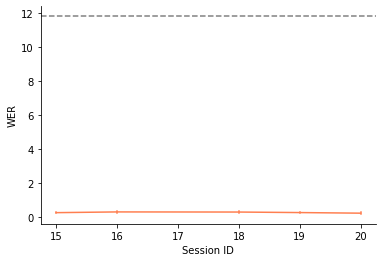

In [264]:
# Get WERs for subset of sessions tested in Nature paper:

sessions_wers = testSubset(model, testset, sessions = [15, 16, 18, 19, 20], device = device)

means = list()
for key, value in sessions_wers.items():
    lower, upper = getBootstrappedCIs(value, alpha = 5, n_bootstraps = 10000)
    plt.plot([key, key], [lower, upper], c = 'coral')
    means.append(np.mean(value))
plt.plot(sessions_wers.keys(), means, c = 'coral')
plt.xlabel('Session ID')
plt.ylabel('WER')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.axhline(11.8, linestyle = '--', c ='k', alpha = 0.5)

print('Overall mean WER =', np.mean(np.concatenate([x for x in sessions_wers.values()])))

TODO implementation:
- get hydra working
- add softsign activation to day-specific input layer (paper suggestion)
- add both pre and post-activation dropout to day-specific input (paper suggestion)
- try L2 regularization (paper suggestion)
- stack windowed bins together as input features (paper suggestion) 

In [63]:
gc.collect()
torch.cuda.empty_cache()

In [102]:
gc.collect()
torch.cuda.empty_cache()

dataloader = DataLoader(dataset=trainset, shuffle=True, num_workers=0, 
                       collate_fn = trainset.collate_fn,
                       drop_last = False, batch_size=FLAGS.batch_size, pin_memory=True)

def old():
    for i, example in enumerate(dataloader):
        schedule_lr(batch_idx)

        #X_raw = addNoise(example['neural'], offset_strength = 0, whitenoise_strength = 0.2, randomwalk_strength = 0)
        X_raw = example['neural'].to(device, non_blocking=True)
        y     = nn.utils.rnn.pad_sequence(example['text_int'], batch_first=True).to(device, non_blocking=True)

        if i == 50:
            break

In [103]:
%timeit old()

The slowest run took 20.23 times longer than the fastest. This could mean that an intermediate result is being cached.
18.3 s ± 16.5 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [101]:
%timeit old()

3.2 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
